### 15-Nov-2018 New way of procecessing Sentinel 2A data to dNBR
***
1. [rasterio](https://anaconda.org/conda-forge/rasterio) version = 1.0.11
2. new resampling methode should be adopted along with other modifications
3. we base the new code on the "L2AResaml_Subset_Create2NBR_dNBR_dNBR7class_&_Masked_itWorks-Nodata-Copy1" notebook
***
- Why not to stack the input bands in order to add quality band for cloud masking 

In [1]:
import rasterio, os, pprint, zipfile, re, fiona
from rasterio import Affine
import rasterio.mask
from rasterio.warp import calculate_default_transform, reproject, Resampling #RESAMPLING
#from rasterio.warp import Resampling as RESAMPLING
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import earthpy.spatial as es


# Extarct the S2A bands from Zip, Resample to 30m then save to tif

In [11]:
s2agrep=re.compile('S2A.*.zip')
#wrkdir='..\\data'
wrkdir='../data2'
#rsltdir='..\\resultS2A'
rsltdir='../result2_S2A'
thezip='zip://'
res='30'
tifbands='tifbands'
posProcessdir='../posProcess'

In [3]:
def s2aResample(inputpath, outputpath,res):
    '''
    inputpath : bands path. in this case it's the path of the band inside the Zipfile
                'zip://data/files.zip!RGB.byte.jp2'
    outputpath: 
    res: str indicating the output resolution 
          i.e. res='30'  for 30m resolution   
    '''
    with rasterio.open(inputpath,'r') as src:
                    src_arr = src.read()
                    new_resolution = (int(res),int(res))
                    
                    new_driver = 'GTiff'
                    meta = src.meta.copy()
                    nodata = src.nodata
#                     pprint.pprint(src.profile)
#                     if nodata is None:                #"'nodata' must be set!"
#                         nodata = 0.0

                    new_transform, new_width, new_height = calculate_default_transform(src.crs, src.crs,
                                                                             src.width, src.height,
                                                                             *src.bounds,
                                                                             resolution=new_resolution)

                    #creating a empty contener for the 30m resolution S2A raster    
                    dst_arr = np.zeros(shape=(src_arr.shape[0],
                                              new_width,
                                             new_height), dtype=np.uint16)

                    meta.update({'affine':new_transform,
                                 'transform': new_transform,
                                 'width': new_width,
                                 'height': new_height,
                                 'nodata': nodata,
                                 'driver': new_driver,
                                 'dtype':'uint16'
                                })   
                
                    reproject(src_arr, dst_arr,
                              src_transform=src.transform,
                              dst_transform=new_transform,
                              width=new_width,
                              height=new_height,
                              src_nodata=nodata,
                              dst_nodata=nodata,
                              src_crs=src.crs,# no change in the CRS
                              dst_crs=src.crs,
                              resample=Resampling.average) #this must be change from NN to averaging
                    
                    with rasterio.open(outputpath,'w', **meta) as dst:
                        dst.write(dst_arr.astype(np.uint16))
#                         pprint.pprint(dst.profile)
#     return (outputpath, meta)

In [4]:
def rasterClip(nbrPath,nbrSubPath, aoiPath):
    '''
    nbr:
    aoi: the path to the Area of interest (aoi)
    '''
    with fiona.open(aoiPath) as srcV:
    #     pprint.pprint(src3[0]["geometry"])
        features = [feature["geometry"] for feature in srcV]
        srcV_crs = srcV.crs
#         print('vector',srcV_crs)
        with rasterio.open(nbrPath) as srcR:
            srcR_crs = srcR.crs.to_dict()
            
            assert srcV_crs == srcR_crs
                
    #         print('raster:', srcR_crs)
            out_image, out_transform = rasterio.mask.mask(srcR, features, crop=True)
            out_meta = srcR.meta.copy() 
            out_meta.update({"driver": "GTiff",
                             "height": out_image.shape[1],
                             "width": out_image.shape[2],
                             "transform": out_transform})
#             nbrSubPath = nbrPath[0:-4]+'_Sub'+nbrPath[-4:]
            with rasterio.open(nbrSubPath, "w", **out_meta) as dst:
                dst.write(out_image)
                plt.imshow(out_image[0])
print('Process ended successfully')

Process ended successfully


In [5]:
def rasterStack (list_to_stack, output_stack):
    """
    list_to_stack: Sorted band's path with the same dtype and extend
    output_stack: stack output path
    shapefile: path to file.shp
    """
#     list_lenght = len(list_to_stack)
#     assert list_lenght==3, 'the bands_list lenght  is {}, it has to be 3 '.format(list_lenght)
    
    # Read metadata of first file
    with rasterio.open(list_to_stack[0]) as src0:
        meta = src0.meta
                
    # Update meta due to stacking
    meta.update({"count": len(list_to_stack) })  #set the number of stack layers
    
    # Read each layer and write it to stack
    with rasterio.open(output_stack, 'w', **meta) as dst:
        for id, layer in enumerate(list_to_stack, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))

In [6]:
def rasterCloudMask(inband, mask_band, outband, sat='S2A'):
    """ inband: band to mask
        mask_band: band cntaining the the masking value. i.e. quaity band
        outband: path to the output band
        sat: satellite used. S2A by default
    """
        
    #read quality band 
    with rasterio.open(mask_band,'r') as src_qb:
        qband=src_qb.read(1)
        
    #read band to mask band    
    with rasterio.open(inband, 'r') as src_inb:
        src_arr = src_inb.read(1,masked=True)

        meta= src_inb.profile
#         pprint.pprint(src_inb.meta)
#         pprint.pprint(src_inb.profile)
    
    #list of values to mask. source: SCL band for S2A
    if sat=='S2A':
        #scl s2a vlaues: 0:NO_DATA, 1: SATURATED-OR-DEFFECTIVE; 2:DARK-AREA-PIXELS
        #3:CLOUD_SHADOWS, 4:VEGETATION, 5:NOT_VEGETATED, 6:WATER, 7:UNCLASSIFIED
        #8:CLOUD_MEDIUM_PROBABILITY, 9:CLOUD_HIGH_PROBABILITY, 10:THIN_CIRRUS, 11:SNOW
        valuestomask= [0,1,2,3,8,9,10,11] 
    
    #create umpty array mask
    cl_mask = np.zeros(qband.shape)
    
    #assign value one to the mask array where Valuestomask contain the listed values
    for value in valuestomask:
        cl_mask[qband == value] = 1
    
    #create array with the shape of the raster input. One band in this case    
    pre_mask = np.broadcast_to(cl_mask == 1, src_arr.shape)

    #mask the the wanted array using the pre_mask
    src_arr_cl_free = np.ma.masked_array(src_arr, mask=pre_mask)

    #assign None value to masked value
    arr_with_None = np.where(cl_mask == 0, src_arr_cl_free, np.nan)

    #write the masked band as raster
    with rasterio.open(outband, 'w', **meta) as dst:
        dst.write_band(1,arr_with_None.astype(rasterio.uint16))


In [7]:
def NBRfuncion (NIRband,SWIRband, NBRband):
    '''
    expecting three band paths, NIR, SWIR and the output (NBR)
    '''
    with rasterio.open(NIRband) as srcNIR:        
        NIRarr=srcNIR.read()
#         pprint.pprint(srcNIR.meta)
        with rasterio.open(SWIRband) as srcSWIR:
            SWIRarr = srcSWIR.read()
#             pprint.pprint(srcSWIR.meta)
            np.seterr(divide='ignore', invalid='ignore')            
            NBRarr = (NIRarr.astype(float) - SWIRarr.astype(float)) / (NIRarr + SWIRarr)
#             NBRarr = NBRarr.astype('float32')
            meta = srcSWIR.meta.copy()
            meta.update({'dtype': rasterio.float32}) #this maybe changed in the future !! have to think about it
#             pprint.pprint(meta)
            with rasterio.open(NBRband,'w', **meta) as dst:
                dst.write(NBRarr.astype(rasterio.float32))
#                 pprint.pprint(dst.profile)
#             print('end NBRfunction')
    return 

In [8]:
def dNBRfunction(preNBR, posNBR, dNBR):
    '''
    preNBR: input path
    posNBR: input path
    dNBR: output path
    '''
    with rasterio.open(preNBR) as srcPRE:        
        PREarr=srcPRE.read()
        
        with rasterio.open(posNBR) as srcPOS:
            POSarr=srcPOS.read()
            
            dNBRarr = (PREarr.astype(float) - POSarr.astype(float)) # don't force to be float. it is already float 32
            
            meta = srcPRE.meta.copy()
            meta.update({'dtype': rasterio.float32})
            with rasterio.open(dNBR,'w', **meta) as dst:
                dst.write(dNBRarr.astype(rasterio.float32))
                pprint.pprint(dst.profile)

In [9]:
def dNBRreclass(dNBR, dNBR7class):
    '''
    this function reclassifies the dNBR
    '''
    with rasterio.open(dNBR) as src:
        arr = src.read()
#         print(arr)
#         print(arr[0, :, :])
#         print(arr)
#         mask = (0.44 <= arr) & (arr < 0.66)
#         plt.imshow(arr[0,:,:],cmap='gray')

        arr[                 (arr < -0.25)] = 11
        arr[(-0.25 <= arr) & (arr < -0.10)] = 12
        arr[(-0.10 <= arr) & (arr < 0.10)] = 13
        arr[(0.10 <= arr) & (arr < 0.27)] = 14
        arr[(0.27 <= arr) & (arr < 0.44)] = 15
        arr[(0.44 <= arr) & (arr < 0.66)] = 16
        arr[(0.66 <= arr) & (arr <= 3.00)] = 17
        arr[arr==11]=1; arr[arr==12]=2; arr[arr==13]=3; arr[arr==14]=4; arr[arr==15]=5; arr[arr==16]=6; arr[arr==17]=7
#         arr8bit= arr.astype(rasterio.uint8) #reducing from float64 to unsigned 8bit
        
#         print(arr1[0, 750:900,1350:1600] - arr[0, 750:900,1350:1600])
#         plt.imshow(arr[0, 780:880,1400:1550])
#         plt.colorbar()
#         plt.hist(arr1[0, 750:900,1350:1600]) #this doesn't work
        
        meta = src.meta.copy()
        meta.update({'dtype': rasterio.uint8,
                    'nodata': 0})

        with rasterio.open(dNBR7class,'w', **meta) as dst:
            dst.write(arr.astype(rasterio.uint8))
            pprint.pprint(dst.profile)

20180907 T29SMC B8A
20180907 T29SMC B12
20180907 T29SMC SCL
20181007 T29SMC B8A
20181007 T29SMC B12
20181007 T29SMC SCL
['../result2_S2A/prt_foct18/20180907/S2A_prt_foct18_20180907_T29SMC_30m_B8A_nbr.tif',
 '../result2_S2A/prt_foct18/20181007/S2A_prt_foct18_20181007_T29SMC_30m_B8A_nbr.tif']
{'count': 1,
 'crs': CRS({'init': 'epsg:32629'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 3660,
 'interleave': 'band',
 'nodata': None,
 'tiled': False,
 'transform': Affine(30.0, 0.0, 399960.0,
       0.0, -30.0, 4300020.0),
 'width': 3660}
{'count': 1,
 'crs': CRS({'init': 'epsg:32629'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 3660,
 'interleave': 'band',
 'nodata': None,
 'tiled': False,
 'transform': Affine(30.0, 0.0, 399960.0,
       0.0, -30.0, 4300020.0),
 'width': 3660}
{'count': 1,
 'crs': CRS({'init': 'epsg:32629'}),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 3660,
 'interleave': 'band',
 'nodata': 0.0,
 'tiled': False,
 'transform': Affine(30.0, 0.0, 399960

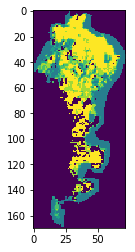

In [12]:
cntrlist = [ name for name in os.listdir(wrkdir) if os.path.isdir(os.path.join(wrkdir, name)) ]
# print(cntrlist[0])
for cntr in cntrlist:
    
#     if not os.path.exists(os.path.join(rsltdir,cntr)):
#         os.makedirs(os.path.join(rsltdir,cntr))
    
    # defining the zip file path
    s2alist= filter(lambda x: s2agrep.search(x),os.listdir(os.path.join(wrkdir,cntr)))
    # print(list(s2alist))
    
    # defining the shp file path
    shpgrep = re.compile('.*.shp')
    shplist = filter(lambda x: shpgrep.search(x),os.listdir(os.path.join(wrkdir,cntr)))
    shpfile = list(shplist)[0]
    aoiPath = os.path.join(wrkdir,cntr,shpfile)
    
    #umpty list of NBR bands
    list_nbr_bands=[]
    
    for s2azip in s2alist:
        s2azipdir = os.path.join(wrkdir,cntr,s2azip)
        date = re.match(r'S2A_.*_(\d{8})', s2azip).groups()
        date = date[0]
    #     print(date)

        
        with zipfile.ZipFile(s2azipdir, 'r') as zip_file:
            B8Agrep = re.compile('.*(B8A_20m).jp2$')
            B12grep = re.compile('.*(B12_20m).jp2$')
            SCLgrep = re.compile('.*(SCL_20m).jp2$')
            B8Apath = list(filter(lambda x: B8Agrep.search(x),zip_file.namelist()))[0]   
            B12path = list(filter(lambda x: B12grep.search(x),zip_file.namelist()))[0]
            SCLpath = list(filter(lambda x: SCLgrep.search(x),zip_file.namelist()))[0]
            
            #umpty band list for stacking
            list_extracted_bands=[]
        
            for bandpath in [B8Apath,B12path,SCLpath]:
                #Input path for rasterio (Apache path style 'zip://dir/file.zip!bandpath)
                jp2bandpath=thezip+s2azipdir+'!/'+bandpath
#                 print('jp2bandpath \n',jp2bandpath)
                
                #output tiff of the extracted bands from zipfile
                scene = jp2bandpath.rsplit('/',1)[1]
                #                 print(scene)
                try : 
                    sattxt, datetxt, tiletxt, bandtxt= re.match(r'(S2A)_.{4}_MSI_L2A_TL_.{3}__(\d{8}).*(T.{5})_(B.{2})_\d{2}m\.jp2$', scene).groups()
                except:
                    tiletxt, datetxt, bandtxt= re.match(r'(T.{5})_(\d{8})T\d{6}_(B.{2}|SCL)_\d{2}m.jp2', scene).groups()
                if not os.path.exists(os.path.join(rsltdir,cntr,datetxt)):
                    os.makedirs(os.path.join(rsltdir,cntr,datetxt))
                print(datetxt, tiletxt, bandtxt)
                tifbandpath=os.path.join(rsltdir,cntr,datetxt,('S2A_'+cntr+'_'+datetxt+'_'+tiletxt+'_'+res+'m_'+bandtxt+'.tif'))
#                 print(tifbandpath)
                  
                #calling the s2aResample function
#                 outputpath, meta = s2aResample(jp2bandpath, tifbandpath,res) #calling the s2aResample function
                s2aResample(jp2bandpath, tifbandpath,res) #calling the s2aResample function
                
                #create list of extracted band paths in the destination directory
                list_extracted_bands.append(tifbandpath)
            
            #calling the cloud masking function
            list_clmasked_bands=[]
            for band in list_extracted_bands[:2]:
                cl_masked_output_band = band[:-4]+'_clmasked.tif'
                rasterCloudMask(band,list_extracted_bands[2],cl_masked_output_band)
                #update list
                list_clmasked_bands.append(cl_masked_output_band)
            
            #calling the NBRfunction
            nbrband = list_clmasked_bands[0][:-13]+'_nbr.tif'
            NBRfuncion(list_clmasked_bands[0],list_clmasked_bands[1], nbrband)
            #update nbr band list
            list_nbr_bands.append(nbrband)
    
#     print('NBR bands', list_nbr_bands.sort)
#     pprint.pprint(list_nbr_bands)
#----------------------------------
    #calling dNBR function
#     list_nbr_bands.sort
# #     print(os.path.basename(list_nbr_bands[0]))
# #     pre_date = re.search(r'S2A_.*_(\d{8})_T{5}_.*\.jp2', os.path.basename(list_nbr_bands[0])).group(0)
# #     print(pre_date)
# #     pos_date = re.match(r'T.{5}_*(\d{8})T\d{6}_B.{2}_*.jp2', os.path.basename(list_nbr_bands[1])).groups()
# #     assert int(pre_date) < int(pos_date), 'the nbr band list is not sorted'
# #     dNBR_name= '_'.join('S2A_dNBR_', cntr, '_pre',pre_date, '_pos', pos_date, '_30m.tif')

#     dNBRpath= os.path.join(rsltdir,cntr,'dNBR.tif')
#     dNBRfunction(list_nbr_bands[0], list_nbr_bands[1],dNBRpath )   
    
#     #calling the dNBR reassification function
    
#     dNBR7class = dNBRpath[:-4]+'_7class.tif'
#     dNBRreclass(dNBRpath,dNBR7class)
    
#     #calling rasterClip
#     dNBR7class_sub = dNBR7class[:-4]+'_Sub.tif'
#     rasterClip(dNBR7class,dNBR7class_sub, aoiPath)
# -------------------------
    #calling dNBR function
    list_nbr_bands.sort
    pprint.pprint(list_nbr_bands)

#     pre_date = re.search(r'S2A_.*_(\d{8})_T{5}_.*\.jp2', os.path.basename(list_nbr_bands[0])).group(0)
#     print(pre_date)
#     pos_date = re.match(r'T.{5}_*(\d{8})T\d{6}_B.{2}_*.jp2', os.path.basename(list_nbr_bands[1])).groups()
#     assert int(pre_date) < int(pos_date), 'the nbr band list is not sorted'
#     dNBR_name= '_'.join('S2A_dNBR_', cntr, '_pre',pre_date, '_pos', pos_date, '_30m.tif')
    dNBR_name= 's2a_dNBR.tif' #temporaray
    
    dNBRpath1= os.path.join(rsltdir,cntr,dNBR_name)
    dNBRfunction(list_nbr_bands[0], list_nbr_bands[1],dNBRpath1 )   
    
    #save in posprocessing directory
    #create fire dir if doesn't exist
    if not os.path.exists(os.path.join(posProcessdir, cntr)):
        os.makedirs(os.path.join(posProcessdir, cntr))
        
    dNBRpath2= os.path.join(posProcessdir,cntr,dNBR_name)
    dNBRfunction(list_nbr_bands[0], list_nbr_bands[1],dNBRpath2 )   
    
    #calling the dNBR reassification function
    #path1
    dNBR7class1 = dNBRpath1[:-4]+'_7class.tif'
    dNBRreclass(dNBRpath1,dNBR7class1)
    #path2
    dNBR7class2 = dNBRpath2[:-4]+'_7class.tif'
    dNBRreclass(dNBRpath2,dNBR7class2)
    
    #calling rasterClip
    #path1
    dNBR7class_sub1 = dNBR7class1[:-4]+'_Sub.tif'
    rasterClip(dNBR7class1,dNBR7class_sub1, aoiPath)
    #path2
    dNBR7class_sub2 = dNBR7class2[:-4]+'_Sub.tif'
    rasterClip(dNBR7class2,dNBR7class_sub2, aoiPath)
        
        
print('Process ended successfully')

#### next steps
- list bands to stack
- stack
- mask cloud
- maybe put all bands in pre and post folders

In [ ]:
help(np.ma.masked_array())